In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from utils.patch_utils import _get_patches
from utils.get_embds import get_embeddings
from utils.queues import Embedding_Queues
from utils.datasets_PASCAL_findContours import PascalVOCDataset

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
patch_size = 14
contrastie_weigth = 0
img_size = 224
batch_size = 16
num_classes = 2

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

dataset_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
output_dir ='dataset/splits/kidney'
model_path = f"output/{patch_size}-{contrastie_weigth}/model_supervised-Pretraining_100-s.pth"

In [6]:
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print('number of val_dataset: ', len(val_dataset))

number of val_dataset:  95


In [7]:
model = torch.load(model_path)
model = model.eval()

model.module.contrast = True

In [8]:
background_embedding_list = []
class1_embedding_list = []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader):
        patch_list = _get_patches(
            imgs, masks,
            classes=num_classes,
            background=True,
            img_size=img_size,
            patch_size=patch_size
        )
        
        qualified_tensor_patch_list = [torch.tensor(patch) if patch is not None else None for patch in patch_list]
        emb_list = get_embeddings(model, qualified_tensor_patch_list, True, batch_size)
        
        # 處理 background_embeddings
        for emb in emb_list[0]:
            if emb is not None:  # 確保 emb 不是 None
                background_embeddings_np = emb.numpy()
                background_embedding_list.append(background_embeddings_np)
            
        # 處理 class1_embeddings
        for emb in emb_list[1]:
            if emb is not None:  # 確保 emb 不是 None
                class1_embeddings_np = emb.numpy()
                class1_embedding_list.append(class1_embeddings_np)

100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


In [9]:
# 將 lists 轉換為 NumPy 陣列並儲存為 .npy 檔案
background_embedding_array = np.array(background_embedding_list)
class1_embedding_array = np.array(class1_embedding_list)

np.save('background_embeddings.npy', background_embedding_array)
np.save('class1_embeddings.npy', class1_embedding_array)

print(len(background_embedding_list))  # 應該是 128 維度的 tensor
print(len(class1_embedding_list))      # 應該是 128 維度的 tensor


24320
1351


In [12]:
import tensorboardX as tbx     # 本範例會使用到tensorboardX套件
writer = tbx.SummaryWriter()

ModuleNotFoundError: No module named 'tensorboardX'

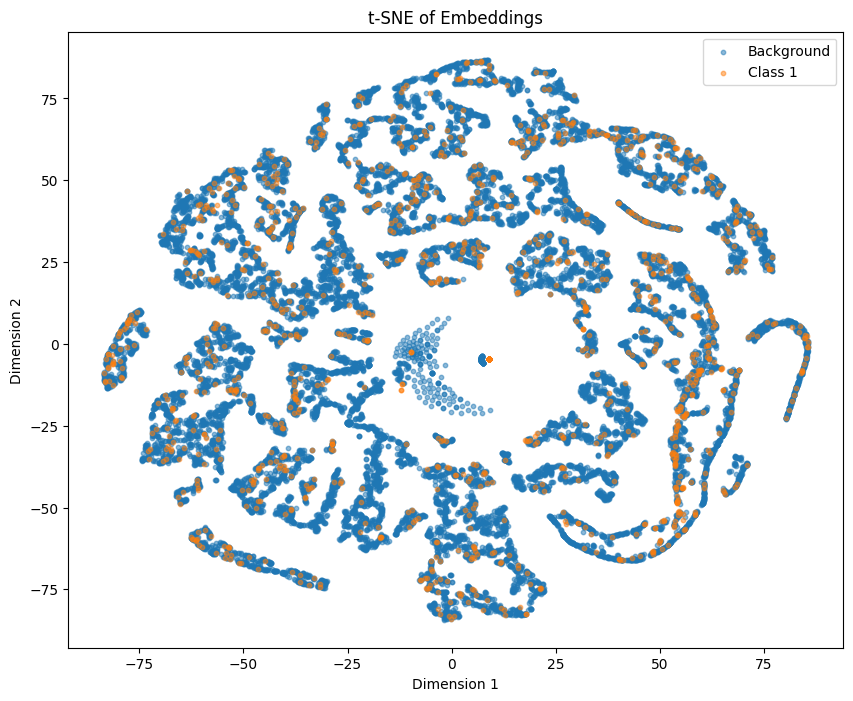

In [11]:
from sklearn.decomposition import PCA

# 将背景和类1的嵌入合并为一个数组
combined_embeddings = np.concatenate((background_embedding_list, class1_embedding_list), axis=0)

# 创建标签列表，背景为0，类1为1
labels = np.array([0]*len(background_embedding_list) + [1]*len(class1_embedding_list))

# 先使用 PCA 将维度降到 50
pca = PCA(n_components=64)
pca_result = pca.fit_transform(combined_embeddings)

# 使用 t-SNE 对 PCA 结果进一步降维到 2 维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(pca_result)

# 绘制 t-SNE 结果
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Background', alpha=0.5, s=10)
plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Class 1', alpha=0.5, s=10)
plt.legend()
plt.title('t-SNE of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()